Populating the interactive namespace from numpy and matplotlib


/Users/ssrujanaa/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['contour']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


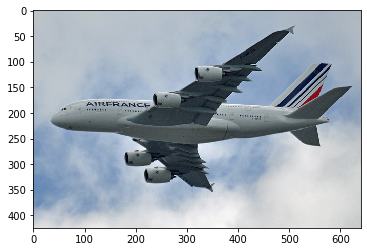

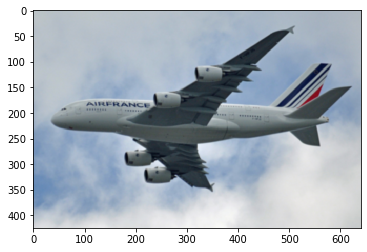

In [8]:
import numpy as np
import cv2

src = cv2.imread('/Users/ssrujanaa/Documents/Fall2020/EE-599/Project/Dataset/train2014/COCO_train2014_000000000081.jpg', 1)
src = src[:,:,::-1]
blurred = cv2.GaussianBlur(src, (5, 5), 0)
# blurred = blurred[:,:,::-1] 


%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgplot = plt.imshow(src)
plt.show()
imgplot = plt.imshow(blurred)
plt.show()

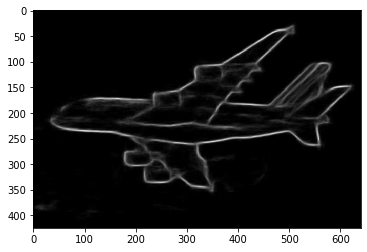

In [9]:
blurred_float = blurred.astype(np.float32) / 255.0
edgeDetector = cv2.ximgproc.createStructuredEdgeDetection("model.yml")
edges = edgeDetector.detectEdges(blurred_float) * 255.0
cv2.imwrite('edge-raw.jpg', edges)


src = cv2.imread('edge-raw.jpg')
imgplot = plt.imshow(src)
plt.show()




In [10]:
def filterOutSaltPepperNoise(edgeImg):
    # Get rid of salt & pepper noise.
    count = 0
    lastMedian = edgeImg
    median = cv2.medianBlur(edgeImg, 3)
    while not np.array_equal(lastMedian, median):
        # get those pixels that gets zeroed out
        zeroed = np.invert(np.logical_and(median, edgeImg))
        edgeImg[zeroed] = 0

        count = count + 1
        if count > 70:
            break
        lastMedian = median
        median = cv2.medianBlur(edgeImg, 3)


edges_8u = np.asarray(edges, np.uint8)
filterOutSaltPepperNoise(edges_8u)
cv2.imwrite('edge.jpg', edges_8u)



contours, hierarchy = cv2.findContours(edges_8u,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)



def findSignificantContour(edgeImg):
    contours, hierarchy = cv2.findContours(edgeImg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    # Find level 1 contours
    level1Meta = []
    for contourIndex, tupl in enumerate(hierarchy[0]):
        # Each array is in format (Next, Prev, First child, Parent)
        # Filter the ones without parent
        if tupl[3] == -1:
            tupl = np.insert(tupl.copy(), 0, [contourIndex])
            level1Meta.append(tupl)
            
    # From among them, find the contours with large surface area.
    contoursWithArea = []
    for tupl in level1Meta:
        contourIndex = tupl[0]
        contour = contours[contourIndex]
        area = cv2.contourArea(contour)
        contoursWithArea.append([contour, area, contourIndex])
		
    contoursWithArea.sort(key=lambda meta: meta[1], reverse=True)
    largestContour = contoursWithArea[0][0]
    return largestContour


contour = findSignificantContour(edges_8u)
# Draw the contour on the original image
contourImg = np.copy(src)
cv2.drawContours(contourImg, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
cv2.imwrite('contour.jpg', contourImg)

True

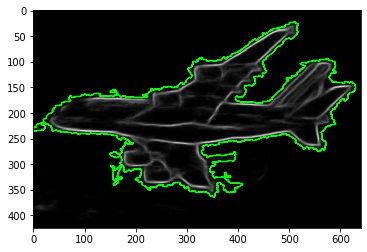

In [11]:
src = cv2.imread('contour.jpg')
imgplot = plt.imshow(src)
plt.show()

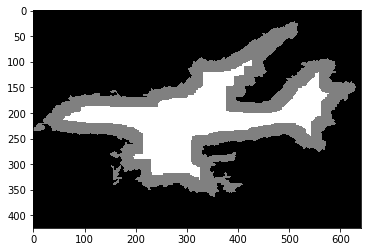

In [12]:
mask = np.zeros_like(edges_8u)
cv2.fillPoly(mask, [contour], 255)

# calculate sure foreground area by dilating the mask
mapFg = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=10)

# mark inital mask as "probably background"
# and mapFg as sure foreground
trimap = np.copy(mask)
trimap[mask == 0] = cv2.GC_BGD
trimap[mask == 255] = cv2.GC_PR_BGD
trimap[mapFg == 255] = cv2.GC_FGD

# visualize trimap
trimap_print = np.copy(trimap)
trimap_print[trimap_print == cv2.GC_PR_BGD] = 128
trimap_print[trimap_print == cv2.GC_FGD] = 255
cv2.imwrite('trimap.png', trimap_print)


src = cv2.imread('trimap.png')
imgplot = plt.imshow(src)
plt.show()

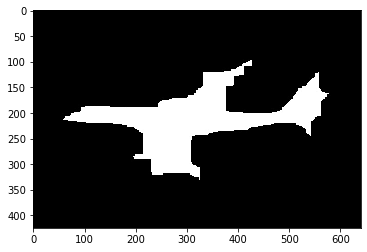

In [13]:
# run grabcut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
rect = (0, 0, mask.shape[0] - 1, mask.shape[1] - 1)
cv2.grabCut(src, trimap, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_MASK)

# create mask again
mask2 = np.where(
    (trimap == cv2.GC_FGD) | (trimap == cv2.GC_PR_FGD),
    255,
    0
).astype('uint8')
cv2.imwrite('mask2.jpg', mask2)

src = cv2.imread('mask2.jpg')
imgplot = plt.imshow(src)
plt.show()

In [16]:
from pymatting import *
import numpy as np

scale = 1.0

image = load_image("/Users/ssrujanaa/Documents/Fall2020/EE-599/Project/Dataset/train2014/COCO_train2014_000000000081.jpg", "RGB", scale, "box")
trimap = load_image("trimap.png", "GRAY", scale, "nearest")

# estimate alpha from image and trimap
alpha = estimate_alpha_cf(image, trimap)

# make gray background
background = np.zeros(image.shape)
background[:, :] = [0.5, 0.5, 0.5]

# estimate foreground from image and alpha
foreground = estimate_foreground_ml(image, alpha)

# blend foreground with background and alpha, less color bleeding
new_image = blend(foreground, background, alpha)
save_image('new_image.jpg',new_image)


Failed to import ahead-of-time-compiled modules. This is expected on first import.
Compiling modules and trying again (this might take a minute).
Successfully imported ahead-of-time-compiled modules.


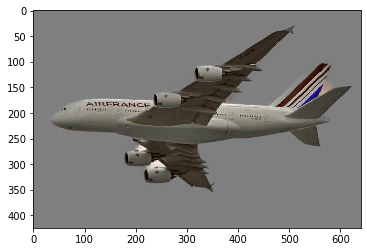

In [17]:
src = cv2.imread('new_image.jpg')
imgplot = plt.imshow(src)
plt.show()